# Подключение библиотеки

In [1]:
import os
import sys
import uuid
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Markdown
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Импорт и анализ данных

In [2]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


# Машинное обучение

In [4]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is not available. Running on CPU.


/home/redalexdad/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Memory Polynomial (MP) модель

In [34]:
class MemoryPolynomialNNTrainer:
    def __init__(self, df, M, K, batch_size=64, learning_rate=0.001, epochs=10, hidden_layers=[64, 128], device=None):
        """
        Инициализация класса для тренировки модели Memory Polynomial с использованием нейронных сетей.

        Args:
            df (pd.DataFrame): Входные данные.
            M (int): Глубина памяти.
            K (int): Степень полинома.
            batch_size (int, optional): Размер батча для обучения. По умолчанию 64.
            learning_rate (float, optional): Скорость обучения для оптимизатора. По умолчанию 0.001.
            epochs (int, optional): Количество эпох. По умолчанию 10.
            hidden_layers (list, optional): Конфигурация скрытых слоев. По умолчанию [64, 128].
            device (str, optional): Устройство для выполнения вычислений ('cpu' или 'cuda'). По умолчанию None.
        """
        # Подготовка данных
        self.df = self.prepare_data(df)
        self.device = self.get_device(device)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.M = M
        self.K = K
        self.hidden_layers = hidden_layers

        # История обучения
        self.history = {"epoch": [], "rmse_real": [], "rmse_imag": []}

        # Генерация уникального ID
        self.model_id = str(uuid.uuid4())

        # Подготовка данных
        X, y_real, y_imag, self.times = self.create_dataset(self.df)
        self.dataset = TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y_real, dtype=torch.float32),
            torch.tensor(y_imag, dtype=torch.float32),
            # torch.tensor(times, dtype=torch.float32)
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)

        # Инициализация модели
        self.model_real = self.create_model(input_size=X.shape[1], output_size=1).to(self.device)
        self.model_imag = self.create_model(input_size=X.shape[1], output_size=1).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer_real = optim.Adam(self.model_real.parameters(), lr=self.learning_rate)
        self.optimizer_imag = optim.Adam(self.model_imag.parameters(), lr=self.learning_rate)

    @staticmethod
    def prepare_data(df):
        """
        Преобразование входных данных: разделение на реальные и мнимые части.

        Args:
            df (pd.DataFrame): Входные данные.

        Returns:
            pd.DataFrame: Обработанные данные.
        """
        df.columns = df.columns.str.lower()
        df['input'] = df['input'].apply(lambda x: complex(x))
        df['output'] = df['output'].apply(lambda x: complex(x))
        df['input_real'] = df['input'].apply(lambda x: x.real)
        df['input_imag'] = df['input'].apply(lambda x: x.imag)
        df['output_real'] = df['output'].apply(lambda x: x.real)
        df['output_imag'] = df['output'].apply(lambda x: x.imag)
        df = df.drop(['input', 'output'], axis=1)
        return df

    @staticmethod
    def get_device( select=None):
        """
        Определение устройства для вычислений (CPU или GPU).

        Args:
            select (str, optional): Выбор устройства ('cpu', 'cuda'). По умолчанию None.

        Returns:
            torch.device: Устройство для вычислений.
        """
        if select is None or select == 'cuda':
            return torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return torch.device('cpu')

    def create_dataset(self, df):
        """
        Создание обучающих данных на основе полиномиальной модели с памятью.

        Args:
            df (pd.DataFrame): Обработанные данные.

        Returns:
            tuple: Матрица признаков X, реальные значения y_real и мнимые значения y_imag.
        """
        x_real = df['input_real'].values
        x_imag = df['input_imag'].values
        y_real = df['output_real'].values[self.M:]
        y_imag = df['output_imag'].values[self.M:]

        N = len(x_real)
        X = np.zeros((N, (self.M + 1) * self.K * 2), dtype=np.float64)
        for n in range(self.M, N):
            index = 0
            for m in range(self.M + 1):
                for k in range(1, self.K + 1):
                    X[n, index] = np.abs(x_real[n - m])**(k-1) * x_real[n - m]
                    X[n, index + 1] = np.abs(x_imag[n - m])**(k-1) * x_imag[n - m]
                    index += 2

        times = np.arange(M, N)  # Генерируем временные метки для каждого наблюдения
        # Проверка порядка временных меток
        assert np.all(np.diff(times) >= 0), "Временные метки не отсортированы!"

        return X[self.M:], y_real, y_imag, times

    def create_model(self, input_size, output_size):
        """
        Создание модели MLP для регрессии.

        Args:
            input_size (int): Размерность входных данных.
            output_size (int): Размерность выходных данных.

        Returns:
            nn.Module: Модель нейронной сети.
        """
        layers = []
        layers.append(nn.Linear(input_size, self.hidden_layers[0]))
        layers.append(nn.ReLU())

        for i in range(1, len(self.hidden_layers)):
            layers.append(nn.Linear(self.hidden_layers[i - 1], self.hidden_layers[i]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(self.hidden_layers[-1], output_size))
        return nn.Sequential(*layers)

    def train(self):
        """
        Обучение модели на реальной и мнимой частях данных.
        """
        self.model_real.train()
        self.model_imag.train()

        for epoch in range(self.epochs):
            total_loss_real = 0
            total_loss_imag = 0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
                
            for batch_idx, (X_batch, y_real_batch, y_imag_batch) in enumerate(progress_bar):
                X_batch, y_real_batch, y_imag_batch = X_batch.to(self.device), y_real_batch.to(self.device), y_imag_batch.to(self.device)

                # Обучение модели для реальной части
                self.optimizer_real.zero_grad()
                pred_real = self.model_real(X_batch)
                loss_real = self.criterion(pred_real, y_real_batch.unsqueeze(1))
                loss_real.backward()
                self.optimizer_real.step()
                total_loss_real += loss_real.item()

                # Обучение модели для мнимой части
                self.optimizer_imag.zero_grad()
                pred_imag = self.model_imag(X_batch)
                loss_imag = self.criterion(pred_imag, y_imag_batch.unsqueeze(1))
                loss_imag.backward()
                self.optimizer_imag.step()
                total_loss_imag += loss_imag.item()
                
                progress_bar.set_postfix(loss_real=f"{loss_real:.10f}", loss_imag=f"{loss_imag:.10f}")

            avg_loss_real = total_loss_real / len(self.train_loader)
            avg_loss_imag = total_loss_imag / len(self.train_loader)

            self.history["epoch"].append(epoch + 1)
            self.history["rmse_real"].append(np.sqrt(avg_loss_real))
            self.history["rmse_imag"].append(np.sqrt(avg_loss_imag))

            print(f"Epoch {epoch+1}/{self.epochs}, RMSE Real: {np.sqrt(avg_loss_real):.6f}, RMSE Imag: {np.sqrt(avg_loss_imag):.6f}")

    def evaluate(self):
        """
        Оценка модели после обучения.
        
        Returns:
            tuple: Значения RMSE для реальной и мнимой частей.
        """
        self.model_real.eval()
        self.model_imag.eval()
        all_preds_real = []
        all_preds_imag = []
        all_true_real = []
        all_true_imag = []
        times = []

        with torch.no_grad():
            for X_batch, y_real_batch, y_imag_batch in self.train_loader:
                X_batch, y_real_batch, y_imag_batch = X_batch.to(self.device), y_real_batch.to(self.device), y_imag_batch.to(self.device)
                
                pred_real = self.model_real(X_batch)
                pred_imag = self.model_imag(X_batch)
                
                all_preds_real.append(pred_real.cpu().numpy())
                all_preds_imag.append(pred_imag.cpu().numpy())
                all_true_real.append(y_real_batch.cpu().numpy())
                all_true_imag.append(y_imag_batch.cpu().numpy())
                # times.append(np.arange(len(y_real_batch)))

        # Конкатенация всех предсказаний и истинных значений
        self.pred_real = np.concatenate(all_preds_real)
        self.pred_imag = np.concatenate(all_preds_imag)
        self.true_real = np.concatenate(all_true_real)
        self.true_imag = np.concatenate(all_true_imag)
        # self.times = np.concatenate(times)  # Сохранение временных меток

        # Вычисление RMSE
        rmse_real = np.sqrt(mean_squared_error(self.true_real, self.pred_real))
        rmse_imag = np.sqrt(mean_squared_error(self.true_imag, self.pred_imag))

        print(f"Evaluation RMSE Real: {rmse_real:.6f}, RMSE Imag: {rmse_imag:.6f}")
        return rmse_real, rmse_imag

    def save_model_pt(self, filename_prefix='node', save_dir='models'):
        """
        Сохраняет всю модель PyTorch в формате .pt.

        Args:
            filename_prefix (str, optional): Префикс имени файла. По умолчанию 'node'.
            save_dir (str, optional): Директория для сохранения модели. По умолчанию 'models'.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.pt"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        os.makedirs(path, exist_ok=True)
        torch.save(self.model_real.state_dict(), os.path.join(path, f"model_real_{self.model_id}.pt"))
        torch.save(self.model_imag.state_dict(), os.path.join(path, f"model_imag_{self.model_id}.pt"))
        print(f"Models saved in {path}")
     
    def save_prediction(self, predictions, filename_prefix="predictions", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")
         
    def save_training_history(self, filename_prefix="training_history", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(self.history)
        df_history.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")
        
    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse_real"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE Real')
        axs[0].plot(epochs, self.history["rmse_imag"], marker='o', linestyle='-', color='r', markersize=5, label='RMSE Imag')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse_real"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE Real')
        axs[1].plot(epochs[mid_index:], self.history["rmse_imag"][mid_index:], marker='o', linestyle='-', color='r', markersize=5, label='RMSE Imag')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.005e2):
        """
        Построение графиков предсказанных и истинных значений для реальной и мнимой частей.
    
        Args:
            time_start (float, optional): Начальное время для фильтрации данных. По умолчанию 0.
            time_end (float, optional): Конечное время для фильтрации данных. По умолчанию 1.005e2.
        """
        # Проверяем, что оценка была выполнена, и данные сохранены
        # if not hasattr(self, 'times') or not hasattr(self, 'true_real') or not hasattr(self, 'pred_real'):
        #     raise ValueError("Необходимо сначала выполнить evaluate(), чтобы сохранить предсказанные значения.")
            
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_real = self.true_real[mask]
        filtered_true_imag = self.true_imag[mask]
        filtered_pred_real = self.pred_real[mask]
        filtered_pred_imag = self.pred_imag[mask]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_real, label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_pred_real, label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_imag, label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_pred_imag, label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        plt.tight_layout()
        plt.show()
        
    def print_model_summary(self, filename_prefix="model_parameters", save_dir='history'):
        """
        Выводит информацию о модели: архитектуру, параметры и их размерности.
        """
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}_{self.model_id}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_params = pd.DataFrame(columns=['Parameter name', 'Parameter shape', 'Parameter count'])
        
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)

            # Добавляем информацию о параметре в DataFrame
            df_params.loc[len(df_params)] = [name, param.shape, param_count] 
            
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)
        
        # Сохраняем DataFrame в CSV файл
        df_params.to_csv(filepath, index=False)

#### Установка параметров

In [35]:
M = 2  # Глубина памяти
K = 1  # Степень полинома

In [36]:
batch_size=1024*1
learning_rate=1e-4
epochs=2
hidden_layers=[2**6, 2**7, 2**7, 2**6]

In [37]:
%%time
# Создание экземпляра класса с настройкой гиперпараметров
model_nn = MemoryPolynomialNNTrainer(
    df, 
    M, K, 
    batch_size,
    learning_rate, 
    epochs, 
    hidden_layers, 
    device=None
)

CPU times: user 1.46 s, sys: 18 ms, total: 1.48 s
Wall time: 1.46 s


In [38]:
# model_nn.print_model_summary()

#### Обучение модели

In [39]:
%%time
model_nn.train()

Epoch 1/2:   0%|          | 0/168 [00:00<?, ?batch/s]

Epoch 1/2, RMSE Real: 1.736773, RMSE Imag: 1.743705


Epoch 2/2:   0%|          | 0/168 [00:00<?, ?batch/s]

Epoch 2/2, RMSE Real: 0.547631, RMSE Imag: 0.544688
CPU times: user 40.8 s, sys: 3.19 s, total: 44 s
Wall time: 5.52 s


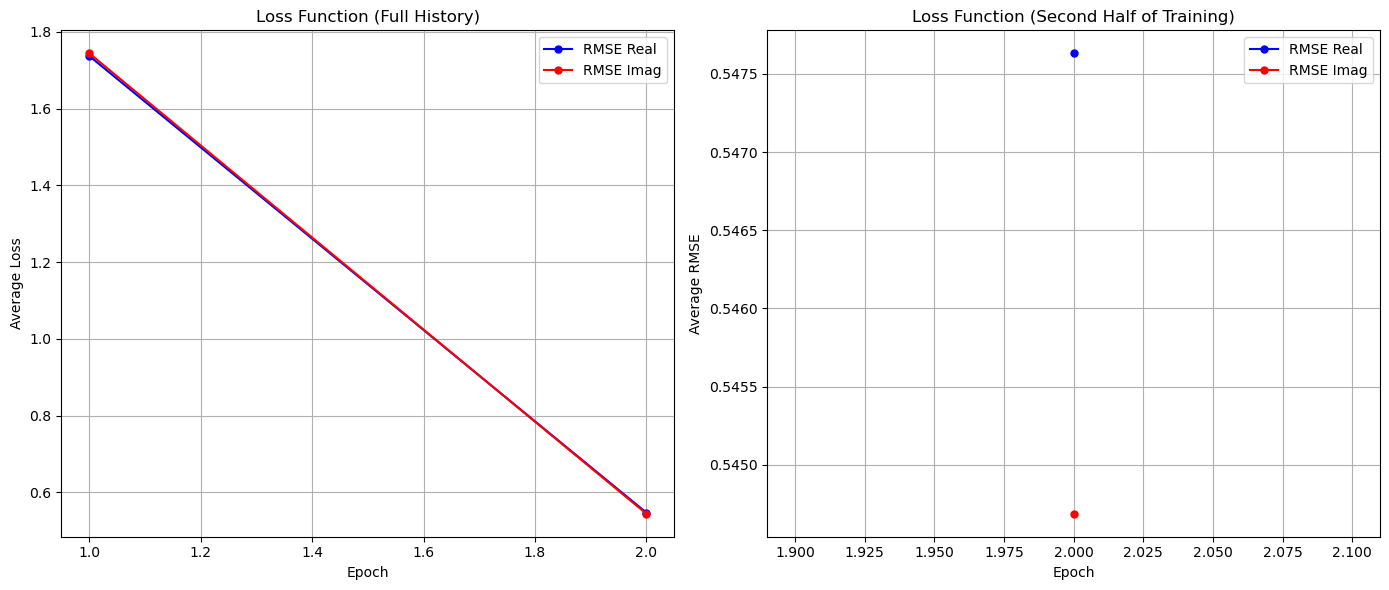

In [40]:
model_nn.plot_training_history()

#### Предсказание и сохранение модели после обучения

In [41]:
model_nn.evaluate()

Evaluation RMSE Real: 0.456295, RMSE Imag: 0.466303


(0.4562952, 0.46630302)

In [42]:
# model_nn.save_model()

#### Демонстрация

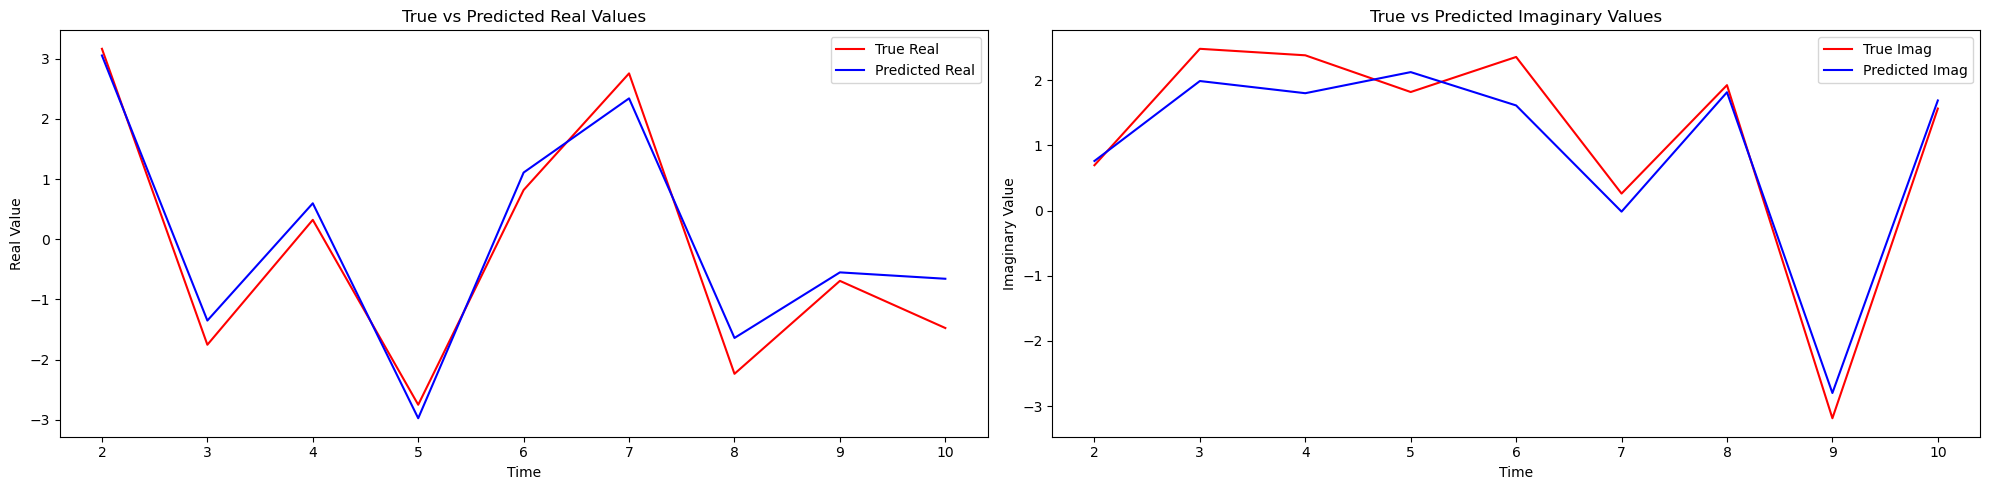

In [44]:
model_nn.plot_predictions(time_start=0, time_end=10)

In [56]:
model_nn.dataset.tensors

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.4135, -0.5725, -0.1977, -0.7695, -0.1746, -0.6796],
         [-0.5913, -0.1578, -0.4135, -0.5725, -0.1977, -0.7695],
         [-0.5201,  0.2421, -0.5913, -0.1578, -0.4135, -0.5725]]),
 tensor([[ 0.0000e+00,  1.4013e-45],
         [-0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00],
         ...,
         [ 3.2080e+00, -1.3911e-01],
         [ 2.4259e+00, -1.9272e+00],
         [ 6.8146e-01, -2.9794e+00]]),
 tensor([2.0000e+00, 3.0000e+00, 4.0000e+00,  ..., 1.7203e+05, 1.7203e+05,
         1.7203e+05]))

In [55]:
model_nn.df.info

<bound method DataFrame.info of               input_real  input_imag   output_real   output_imag
time                                                            
0.000000e+00    0.000000    0.000000  1.078500e-42 -9.305350e-43
5.000000e-09    0.000000    0.000000  4.001670e-44  4.808050e-45
1.000000e-08    0.000000    0.000000  5.731020e-46  1.231430e-45
1.500000e-08    0.000000    0.000000 -2.473560e-47  3.896720e-47
2.000000e-08    0.000000    0.000000 -1.564970e-48  2.918210e-51
...                  ...         ...           ...           ...
8.601350e-04   -0.174560   -0.679641  3.096800e+00  9.435560e-01
8.601400e-04   -0.197720   -0.769545  3.160930e+00  9.427330e-01
8.601450e-04   -0.413468   -0.572511  3.208030e+00 -1.391130e-01
8.601500e-04   -0.591335   -0.157788  2.425870e+00 -1.927240e+00
8.601550e-04   -0.520142    0.242103  6.814600e-01 -2.979350e+00

[172032 rows x 4 columns]>

In [57]:
print(model_nn.dataset.tensors[0].shape)  # Размерности входных данных
print(model_nn.dataset.tensors[1].shape)  # Размерности выходных данных
print(model_nn.df.shape)  # Размерности DataFrame


torch.Size([172030, 6])
torch.Size([172030, 2])
(172032, 4)


In [58]:
print(model_nn.df.isnull().sum())  # Проверка на наличие NaN


input_real     0
input_imag     0
output_real    0
output_imag    0
dtype: int64


In [59]:
print("Первые 10 значений входных данных:")
print(model_nn.df[['input_real', 'input_imag']].head(10))

print("Первые 10 значений в тензорах:")
print(model_nn.dataset.tensors[0][:10])


Первые 10 значений входных данных:
              input_real  input_imag
time                                
0.000000e+00    0.000000         0.0
5.000000e-09    0.000000         0.0
1.000000e-08    0.000000         0.0
1.500000e-08    0.000000         0.0
2.000000e-08    0.000000         0.0
2.500000e-08    0.000000         0.0
3.000000e-08    0.000000         0.0
3.500000e-08    0.000000         0.0
4.000000e-08    0.000000         0.0
4.500000e-08    0.000114         0.0
Первые 10 значений в тензорах:
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
     

In [61]:
time_start = 0
time_end = 1e-2

time_step = model_nn.df.index[1] - model_nn.df.index[0]  # Определяем шаг времени
time_values = np.arange(time_start, time_end, time_step)

In [ ]:
# Задаем временные параметры
time_start = 0
time_end = 100
time_step = model_nn.df.index[1] - model_nn.df.index[0]  # Определяем шаг времени
time_values = np.arange(time_start, time_end, time_step)

# Ограничим количество временных значений до длины данных в DataFrame и тензорах
num_points = min(len(model_nn.df), len(time_values))

plt.figure(figsize=(12, 6))

# График данных из DataFrame
plt.subplot(1, 2, 1)
plt.title("Input Data from DataFrame")
plt.plot(model_nn.df['input_real'][:num_points], label='Input Real')
plt.plot(model_nn.df['input_imag'][:num_points], label='Input Imag')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(time_start, time_end)
plt.xticks(ticks=np.arange(0, time_end + 1e-3, 2e-3))  # Настраиваем деления на оси X
plt.legend()

# График данных из тензоров
plt.subplot(1, 2, 2)
plt.title("Input Data from Tensors")
plt.plot(model_nn.dataset.tensors[0][:num_points, 0].numpy(), label='Input Real (Tensor)')
plt.plot(model_nn.dataset.tensors[0][:num_points, 1].numpy(), label='Input Imag (Tensor)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, num_points)
plt.xticks(ticks=np.arange(0, num_points + 1, 20000))  # Настраиваем деления на оси X
plt.legend()

plt.tight_layout()
plt.show()

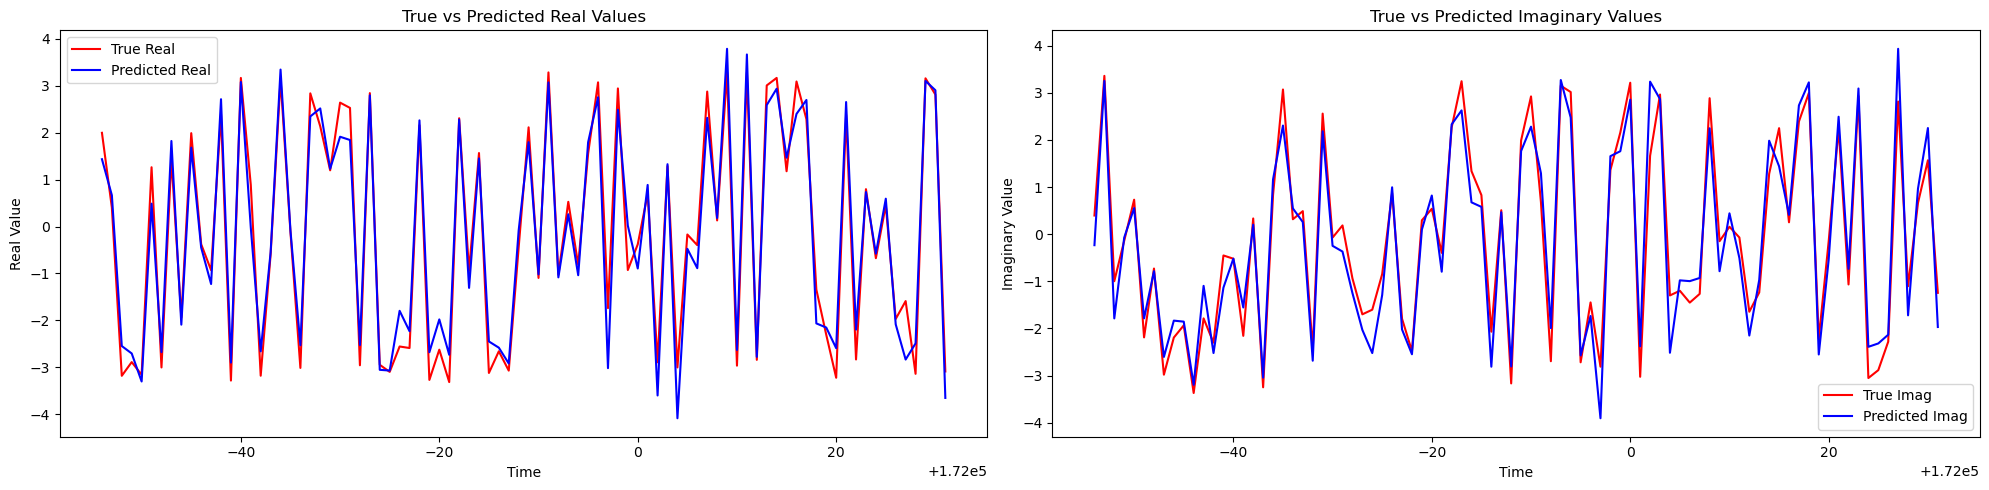

In [62]:
model_nn.plot_predictions(time_start=model_nn.df.__len__() * .9995, time_end=model_nn.df.__len__())

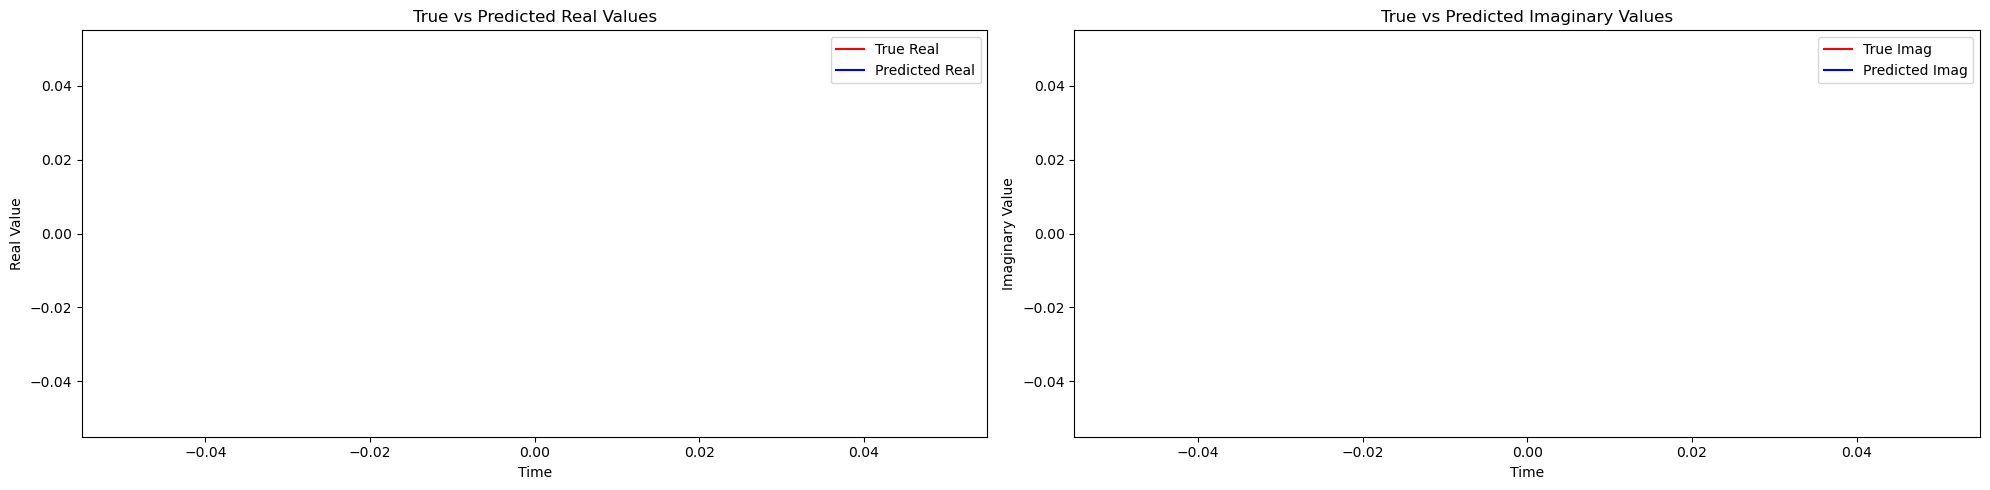

In [46]:
model_nn.plot_predictions(time_start=1e-4, time_end=1.01e-4)

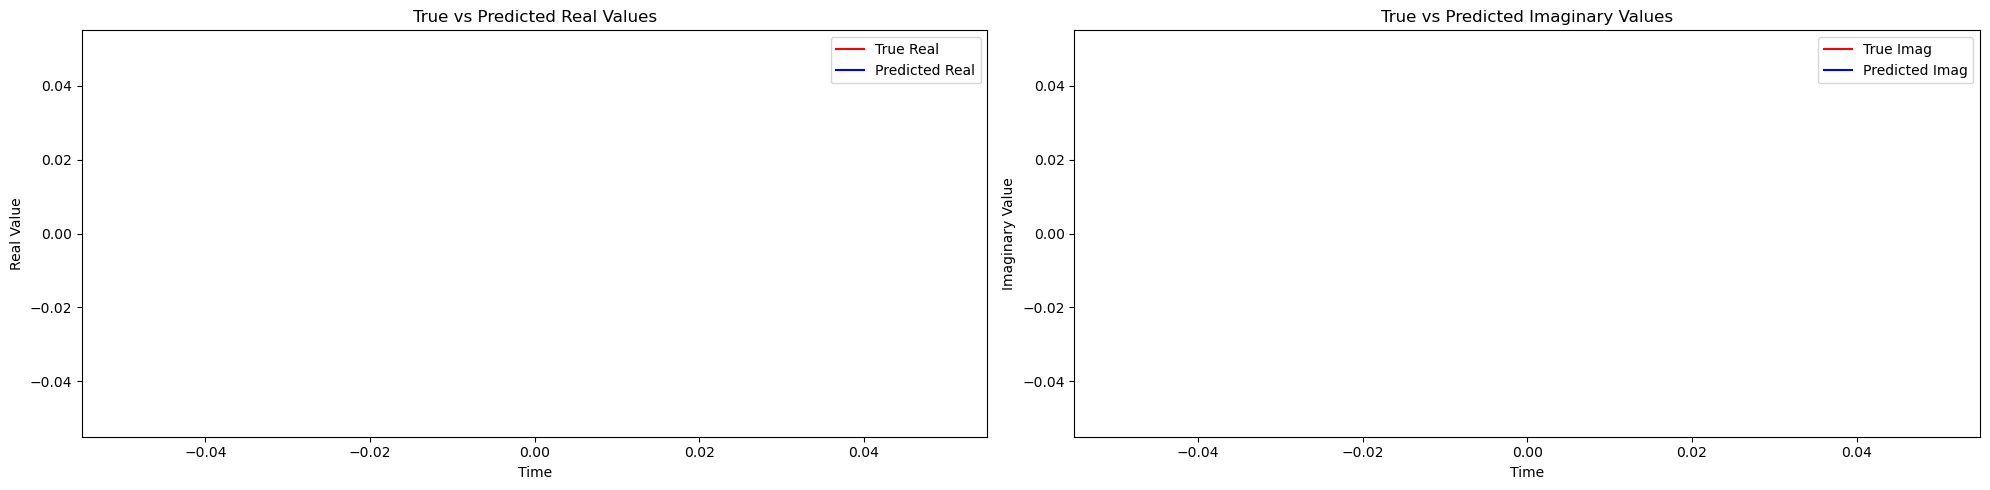

In [70]:
model_nn.plot_predictions(time_start=3e-4, time_end=3.01e-4)

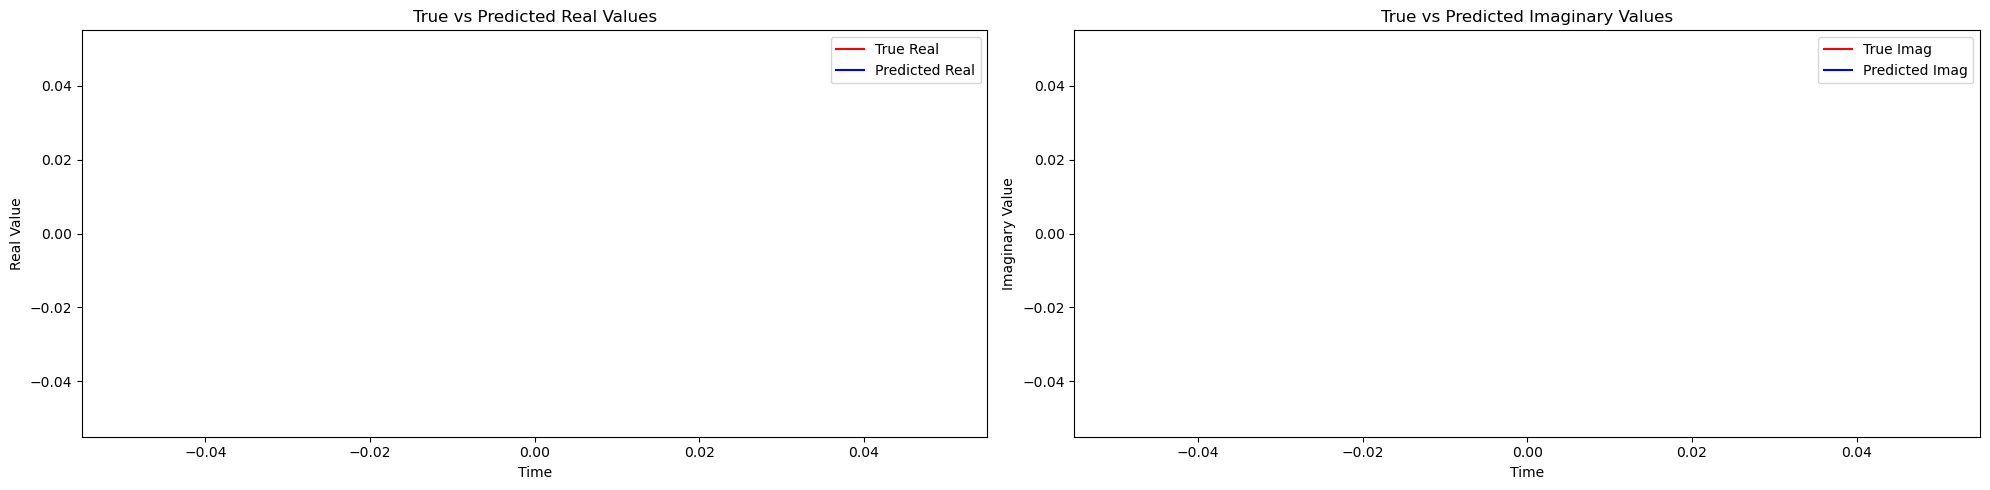

In [71]:
model_nn.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)